# NOTE
[0512 note]
*  use ALL camera devices to train Federated Model --> 4

*  D#5/6/8/9 local model and global model for evaluation

*  Adam // 1000 baseline_data // other device benign_tr:benign_test -> 0.8:0.2

[0519 note]
*  Add 'server_aggregate_M()' function for FedAvgM

*  'server_aggregate()' for FedAvg

[0520 note]

*  use D#568 for training FL, test on D#123479

[0528 note]

* train #12347, test #5689
* train #12345678, test #9

[0531 note]

* train #123456789

# Import Libraries/Packages & Datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [ ]:
# load data

d1 = pd.read_parquet('./FinalDataset/Device1.parquet')
d2 = pd.read_parquet('./FinalDataset/Device2.parquet')
d3 = pd.read_parquet('./FinalDataset/Device3.parquet')
d4 = pd.read_parquet('./FinalDataset/Device4.parquet')
d5 = pd.read_parquet('./FinalDataset/Device5.parquet')
d6 = pd.read_parquet('./FinalDataset/Device6.parquet')
d7 = pd.read_parquet('./FinalDataset/Device7.parquet')
d8 = pd.read_parquet('./FinalDataset/Device8.parquet')
d9 = pd.read_parquet('./FinalDataset/Device9.parquet')

d1.shape, d2.shape, d3.shape, d4.shape, d5.shape, d6.shape, d7.shape, d8.shape, d9.shape

# load dataset for other types of devices here.....

# Data Pre-processing

In [ ]:
def pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'].drop('type', axis=1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign'].drop('type', axis=1)
    abnormal['type'] = 1

    # Split benign data evenly into three parts
    benign_train, benign_tr, benign_test = np.split(benign, [int((1/3)*len(benign)), int((2/3)*len(benign))])
    benign_test_mix = benign_test.copy()  # With label 116

    train_label = benign_train['type']
    benign_train = benign_train.drop('type', axis=1)
    benign_tr = benign_tr.drop('type', axis=1)

    # Create mixed data
    abnormal_sample = abnormal.sample(frac=1)  # Use all abnormal data (frac = 0.1 for selecting 10%)
    mix_temp = pd.concat([benign_test_mix, abnormal_sample]).sample(frac=1, random_state=1)

    mix = mix_temp.copy()  # Mix with label # 116
    mix_data = mix_temp.drop('type', axis=1)  # Only data (115)
    mix_label = mix['type']

    # Standardize data using StandardScaler
    scaler = StandardScaler()
    benign_train = scaler.fit_transform(benign_train)  # 115 all benign
    benign_tr = scaler.transform(benign_tr)  # 115 all benign
    mix_data = scaler.transform(mix_data)  # ([xxx, 115])

    # Convert data to tensors
    benign_tr = torch.from_numpy(benign_tr).float().to(device)  # 115 all benign --> for calculating threshold
    mix_data = torch.from_numpy(mix_data).float().to(device)  # 115 benign + abnormal --> for evaluation
    mix_label = torch.tensor(mix_label.values)

    return benign_train, benign_tr, mix_data, mix_label

In [ ]:
def other_pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'].drop('type', axis=1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign'].drop('type', axis=1)
    abnormal['type'] = 1

    # Split benign data into training and testing sets
    benign_tr, benign_test = train_test_split(benign, test_size=0.2, random_state=5703)
    benign_tr = benign_tr.drop('type', axis=1)

    # Create mixed data
    abnormal_sample = abnormal.sample(frac=1)  # Use all abnormal data (frac = 0.1 for selecting 10%)
    mix_temp = pd.concat([benign_test, abnormal_sample]).sample(frac=1, random_state=1)

    mix = mix_temp.copy()  # Mix data with label # 116
    mix_data = mix_temp.drop('type', axis=1)  # No label (115)
    mix_label = mix['type']

    # Standardize data using StandardScaler
    scaler = StandardScaler()
    benign_tr = scaler.fit_transform(benign_tr)
    mix_data = scaler.transform(mix_data)

    # Convert data to tensors
    benign_tr = torch.from_numpy(benign_tr).float().to(device)  # 115 all benign --> for calculating threshold
    mix_data = torch.from_numpy(mix_data).float().to(device)  # 115 data (benign + abnormal) --> for evaluation
    mix_label = torch.tensor(mix_label.values)  # 0/1 label (benign + abnormal) --> for evaluation

    return benign_tr, mix_data, mix_label

In [33]:
# for Federated Model training
benign_train_1, benign_tr_1, mix_data_1, mix_label_1 = pre_processing(d1)
benign_train_2, benign_tr_2, mix_data_2, mix_label_2 = pre_processing(d2)
benign_train_3, benign_tr_3, mix_data_3, mix_label_3 = pre_processing(d3)
benign_train_4, benign_tr_4, mix_data_4, mix_label_4 = pre_processing(d4)
benign_train_5, benign_tr_5, mix_data_5, mix_label_5 = pre_processing(d5)
benign_train_6, benign_tr_6, mix_data_6, mix_label_6 = pre_processing(d6)
benign_train_7, benign_tr_7, mix_data_7, mix_label_7 = pre_processing(d7)
benign_train_8, benign_tr_8, mix_data_8, mix_label_8 = pre_processing(d8)
benign_train_9, benign_tr_9, mix_data_9, mix_label_9 = pre_processing(d9)

# Prepare for training

## Hyperparameters

In [34]:
num_clients = 9      # Number of clients
num_selected = 3     # Typically, num_selected is around 30–40% of the num_clients.
batch_size = 128
baseline_num = 1000  # choose some data from the train set to retrain the data from trained model 
num_rounds = 3#100      # Total number of communication rounds for the global model to train.
epochs = 5          # for train client model
retrain_epochs = 5  # Total number of retraining rounds on the global server after receiving the model weights 
                      # from all the clients that participated in the communication round.

## Retraining Mechanism

In [35]:
def baseline_data(size=baseline_num, batch_size=batch_size):
    loaders = {
        'D1': torch.utils.data.DataLoader(benign_train_1, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_1, replacement=True, num_samples=size)),
        'D2': torch.utils.data.DataLoader(benign_train_2, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_2, replacement=True, num_samples=size)),
        'D3': torch.utils.data.DataLoader(benign_train_3, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_3, replacement=True, num_samples=size)),
        'D4': torch.utils.data.DataLoader(benign_train_4, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_4, replacement=True, num_samples=size)),
        'D5': torch.utils.data.DataLoader(benign_train_5, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_5, replacement=True, num_samples=size)),
        'D6': torch.utils.data.DataLoader(benign_train_6, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_6, replacement=True, num_samples=size)),
        'D7': torch.utils.data.DataLoader(benign_train_7, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_7, replacement=True, num_samples=size)),
        'D8': torch.utils.data.DataLoader(benign_train_8, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_8, replacement=True, num_samples=size)),
        'D9': torch.utils.data.DataLoader(benign_train_9, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_9, replacement=True, num_samples=size))
    }

    return loaders


## FedAvg / FedAvgM

In [36]:
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        avg_weight = sum(client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(n)) / n
        global_dict[k] -= avg_weight
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    temp_dict = copy.deepcopy(global_dict)
    v = {x: 1 for x in global_dict}

    for i, k in enumerate(global_dict.keys()):
        avg_weight = sum(client_models[j].state_dict()[k].float() * (n * client_lens[j] / total) for j in range(n)) / n
        temp_dict[k] = avg_weight
        temp_v = 0.9 * v[k] + temp_dict[k]
        global_dict[k] -= temp_v
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Utilities

In [37]:
def train_data_loaders(batch_size=batch_size):
    client_loaders = {}
    for i in range(1, 10):
        data = torch.utils.data.DataLoader(globals()[f'benign_train_{i}'], batch_size=batch_size, shuffle=True)
        client_loaders[f'D{i}'] = data

    return client_loaders


In [38]:
import torch.nn.functional as F

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for _ in range(epoch):
        running_loss = 0.0
        for data in train_data:
            optimizer.zero_grad()
            output = client_model(data.float().to(device))
            loss = F.mse_loss(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_data)
    return epoch_loss

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [39]:
input_dim = 115

class AEModel(nn.Module):
    def __init__(self):
        super(AEModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(0.75 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75 * input_dim), int(0.5 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5 * input_dim), int(0.33 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33 * input_dim), int(0.25 * input_dim)),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(int(0.25 * input_dim), int(0.33 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33 * input_dim), int(0.5 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5 * input_dim), int(0.75 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75 * input_dim), int(input_dim)),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Initialisation

In [40]:
# Initialize global model and client models
global_model = AEModel().to(device)
client_models = [AEModel().to(device) for _ in range(num_selected)]
for client_model in client_models:
    client_model.load_state_dict(global_model.state_dict())

# Initialize optimizers for client models
client_optimizers = [torch.optim.SGD(client_model.parameters(), lr=0.012, weight_decay=1e-05, momentum=0.9) for client_model in client_models]


In [41]:
baseline_data = baseline_data() # size = 1000
train_loader = train_data_loaders() #batch_size=128
devices = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']

# Training Federated Model

In [42]:
# Train Client Model and Global Model
client_losses = []
global_losses = []

start_time = time.time()

for round_idx in range(num_rounds):  # Total number of rounds
    print('\nRound:', round_idx + 1)
    client_indices = np.random.permutation(num_clients)[:num_selected]  # Randomly select clients for training
    print('Client Indices:', client_indices)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_indices]

    # Client Update
    client_loss = 0
    for i in tqdm(range(num_selected)):
        client_syn(client_models[i], global_model)
        client_loss += client_update(client_models[i], client_optimizers[i], train_loader[devices[client_indices[i]]], epochs)
    client_losses.append(client_loss)

    # Retraining on the Global Server
    global_loss_retrain = 0
    for i in tqdm(range(num_selected)):
        global_loss_retrain += client_update(client_models[i], client_optimizers[i], baseline_data[devices[client_indices[i]]], retrain_epochs)
    global_losses.append(global_loss_retrain / num_selected)

    # Aggregate Models
    server_aggregate_M(global_model, client_models, client_lens)  # FedAvgM

    print('\nClient Loss:', client_loss)
    print('Global Loss:', global_loss_retrain / num_selected)

# Save the Global Model
torch.save(global_model, 'global.pt')

time_required = time.time() - start_time
print('\nTime Required: {} mins'.format(time_required / 60))



Round: 1
Client Indices: [5 4 6]


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]



Client Loss: 1.7228846332793566
Global Loss: 0.5241346284747124

Round: 2
Client Indices: [8 1 6]


100%|██████████| 3/3 [00:00<00:00,  8.97it/s]



Client Loss: 4.198320899995602
Global Loss: 1.422019124031067

Round: 3
Client Indices: [0 1 2]


100%|██████████| 3/3 [00:00<00:00, 12.68it/s]


Client Loss: 4.391100438620812
Global Loss: 1.5620046804348628

Time Required: 0.2386404037475586 mins


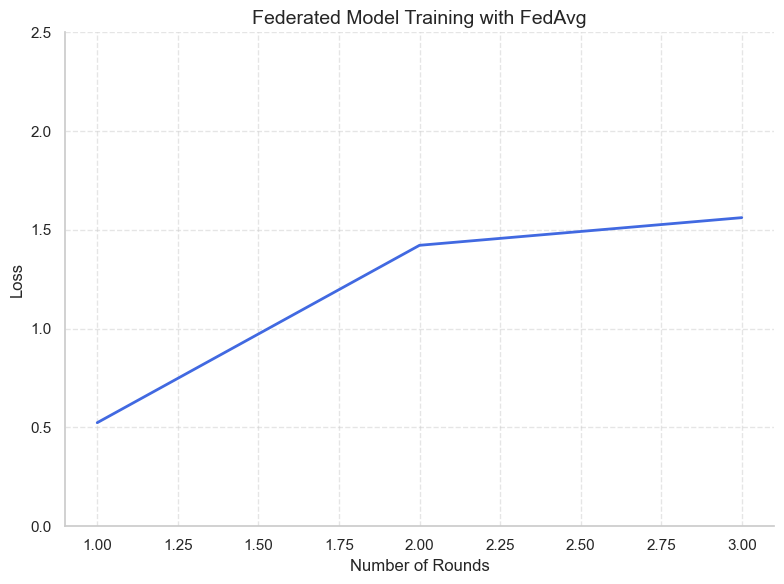

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot train_loss_global
rounds = range(1, num_rounds + 1)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(rounds, global_losses, color='royalblue', linewidth=2)
plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim((0, 2.5))
plt.title('Federated Model Training with FedAvg', fontsize=14)

# Add grid and remove top/right spines
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


# Evaluation

In [44]:
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score


def get_threshold(model, tr_data):
    model.eval()
    mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    tr = mse.mean() + mse.std()
    return tr

def calculate_performance(y_actual, y_pred):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
            TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
            FP += 1
        if y_actual[i] == y_pred[i] == 0:
            TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
            FN += 1
    return TP, FP, TN, FN

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    mse = np.mean(np.power(mix_data.cpu().detach().numpy() - model(mix_data).cpu().detach().numpy(), 2), axis=1)

    predictions = []
    for i in mse:
        if i > tr:
            predictions.append(1)
        else:
            predictions.append(0)

    mix_label_list = mix_label.tolist()
    TP, FP, TN, FN = calculate_performance(mix_label_list, predictions)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * ((precision * recall) / (precision + recall))
    TPR = round((TP / (TP + FN)), 6)
    FPR = round((FP / (FP + TN)), 6)

    specificity = TN / (FP + TN)  # Specificity or True Negative Rate
    NPV = TN / (TN + FN)  # Negative Predictive Value
    FNR = FN / (TP + FN)  # False Negative Rate
    auc = roc_auc_score(mix_label_list, predictions)

    performance = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1_score': F1_score,
        'TPR': TPR,
        'FPR': FPR,
        'specificity': specificity,
        'NPV': NPV,
        'AUC': auc
    }

    return performance




In [45]:
# load model
global_model = torch.load('global.pt')

# Test on client devices

In [46]:
# Calculate TR
tr_1 = get_threshold(global_model, benign_tr_1)
tr_2 = get_threshold(global_model, benign_tr_2)
tr_3 = get_threshold(global_model, benign_tr_3)
tr_4 = get_threshold(global_model, benign_tr_4)
tr_5 = get_threshold(global_model, benign_tr_5)
tr_6 = get_threshold(global_model, benign_tr_6)
tr_7 = get_threshold(global_model, benign_tr_7)
tr_8 = get_threshold(global_model, benign_tr_8)
tr_9 = get_threshold(global_model, benign_tr_9)

In [47]:
# use global model & device's TR
print("D1: ")
get_mix_result(global_model, tr_1, mix_data_1, mix_label_1)

D1: 


{'accuracy': 0.999866026027489,
 'precision': 0.9998802704236982,
 'recall': 0.9999834838709677,
 'F1_score': 0.9999318744838975,
 'TPR': 0.999983,
 'FPR': 0.007023,
 'specificity': 0.9929765076289658,
 'NPV': 0.9990253411306043,
 'AUC': 0.9964799957499667}

In [48]:

print('\nD2: ')
get_mix_result(global_model, tr_2, mix_data_2, mix_label_2)



D2: 


{'accuracy': 0.9997823810894003,
 'precision': 0.9997812728220545,
 'recall': 1.0,
 'F1_score': 0.9998906244493245,
 'TPR': 1.0,
 'FPR': 0.041181,
 'specificity': 0.9588194921070693,
 'NPV': 1.0,
 'AUC': 0.9794097460535346}

In [49]:
print("\nD3: ")
get_mix_result(global_model, tr_3, mix_data_3, mix_label_3)


D3: 


{'accuracy': 0.3763060279145443,
 'precision': 0.999441733148445,
 'recall': 0.35080910240202273,
 'F1_score': 0.5193305541129186,
 'TPR': 0.350809,
 'FPR': 0.004757,
 'specificity': 0.9952432100659813,
 'NPV': 0.05940213210242884,
 'AUC': 0.6730261562340021}

In [50]:

print('\nD4: ')
get_mix_result(global_model, tr_4, mix_data_4, mix_label_4)


D4: 


{'accuracy': 0.9985109756979419,
 'precision': 0.9985583594065156,
 'recall': 0.9998603044928891,
 'F1_score': 0.9992089078491275,
 'TPR': 0.99986,
 'FPR': 0.02282,
 'specificity': 0.9771801280514945,
 'NPV': 0.997745149449397,
 'AUC': 0.9885202162721918}

In [51]:
print("D5: ")
get_mix_result(global_model, tr_5, mix_data_5, mix_label_5)

D5: 


{'accuracy': 0.9992361697152095,
 'precision': 0.9992708280341185,
 'recall': 0.9999451772992249,
 'F1_score': 0.9996078889353565,
 'TPR': 0.999945,
 'FPR': 0.026981,
 'specificity': 0.9730186311420022,
 'NPV': 0.9979208950051978,
 'AUC': 0.9864819042206137}

In [52]:
print('\nD6: ')
get_mix_result(global_model, tr_6, mix_data_6, mix_label_6)



D6: 


{'accuracy': 0.9987020480670111,
 'precision': 0.9987540887803057,
 'recall': 0.999891654263337,
 'F1_score': 0.9993225477888055,
 'TPR': 0.999892,
 'FPR': 0.028047,
 'specificity': 0.971953224922346,
 'NPV': 0.9974997656030253,
 'AUC': 0.9859224395928415}

In [53]:
print('\nD7: ')
get_mix_result(global_model, tr_7, mix_data_7, mix_label_7)


D7: 


{'accuracy': 0.9988339168644407,
 'precision': 0.9991677314959485,
 'recall': 0.9996038034865293,
 'F1_score': 0.9993857199223253,
 'TPR': 0.999604,
 'FPR': 0.015474,
 'specificity': 0.9845260009203866,
 'NPV': 0.9925766977904077,
 'AUC': 0.9920649022034579}

In [54]:
print("\nD8: ")
get_mix_result(global_model, tr_8, mix_data_8, mix_label_8)


D8: 


{'accuracy': 0.9990288461538461,
 'precision': 0.9991017352174866,
 'recall': 0.9999093660399451,
 'F1_score': 0.9995053874811612,
 'TPR': 0.999909,
 'FPR': 0.047266,
 'specificity': 0.9527335952089638,
 'NPV': 0.9950232026363576,
 'AUC': 0.9763214806244545}

In [55]:
print('D9:')
get_mix_result(global_model, tr_9, mix_data_9, mix_label_9)

D9:


{'accuracy': 0.7599855814219965,
 'precision': 0.9999635070082411,
 'recall': 0.7581336656650203,
 'F1_score': 0.8624164931073459,
 'TPR': 0.758134,
 'FPR': 0.003533,
 'specificity': 0.9964669738863288,
 'NPV': 0.03125511924837389,
 'AUC': 0.8773003197756746}

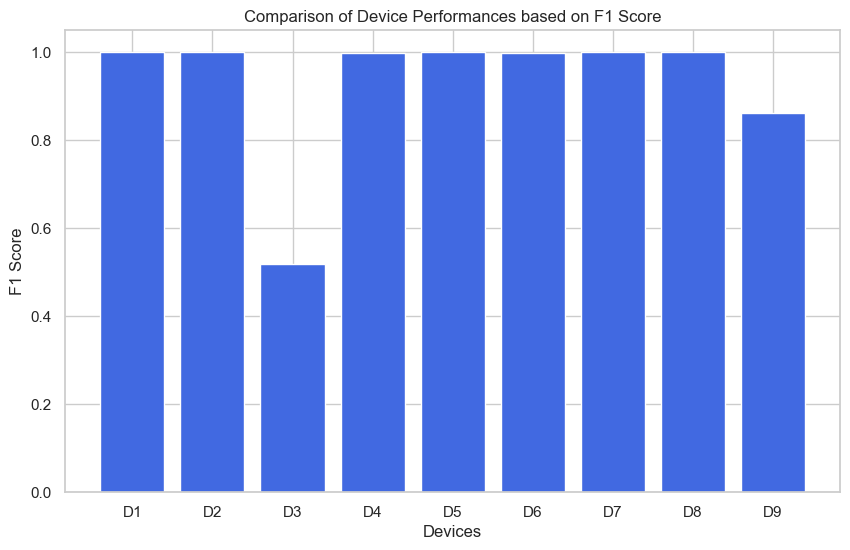

In [58]:
# Create lists to store the performance metrics for each device
devices = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
device_colors = ['royalblue', 'orange', 'green', 'red', 'purple', 'pink', 'cyan', 'brown', 'gray']

f1_scores = []

# Calculate and store the F1 score for each device
for i, tr, mix_data, mix_label in zip(range(1, 10), [tr_1, tr_2, tr_3, tr_4, tr_5, tr_6, tr_7, tr_8, tr_9],
                                      [mix_data_1, mix_data_2, mix_data_3, mix_data_4, mix_data_5, mix_data_6, mix_data_7, mix_data_8, mix_data_9],
                                      [mix_label_1, mix_label_2, mix_label_3, mix_label_4, mix_label_5, mix_label_6, mix_label_7, mix_label_8, mix_label_9]):
    performance = get_mix_result(global_model, tr, mix_data, mix_label)
    f1_scores.append(performance['F1_score'])

# Plotting the F1 scores in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(devices, f1_scores, color=device_colors)
plt.xlabel('Devices')
plt.ylabel('F1 Score')
plt.title('Comparison of Device Performances based on F1 Score')

plt.show()


In [56]:
# Save the trained federated model
torch.save(global_model.state_dict(), 'federated_model.pth')
